In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import sys

module_path = (Path().resolve().parent/ "Modules")
sys.path.append(str(module_path))

import my_modules, model_tuner, model_tuner_multi, features

pd.set_option("display.max_columns", None)
pd.option_context(
        'display.max_info_rows', None,     # 行しきい値を無制限
        'display.max_info_columns', None
        )

plt.rcParams['font.family'] = 'Yu Gothic'

%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [2]:
df = pd.read_csv("../Data/train_data_JV_2008.csv", encoding="cp932")
# odds_df = pd.read_csv("../Data/Time_Series_Odds_win_odds.csv", encoding="shift-jis")

In [3]:
df2 = my_modules.preprocessing(df)

In [4]:
df3 = my_modules.common_process(df2)

C:\Users\ken05\Documents\others\HORSE_RACING\Modules\my_modules.py:77: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["place_num"] = df["place"].replace(place_dict).astype(int)


In [5]:
# 計算に時間がかかりすぎるので、とりあえず2020年からのデータをつかって実験
df3 = df3[df3.year >= 2018]

In [8]:
feature_col = ["waku_num", "horse_num", "sex", "age", "basis_weight", "weight", "inc_dec", "age_type"]
df4, feature_col2 = features.feature_engineering(df3, feature_col)

calculating horse trueskill is in progress
calculating jockey trueskill is in progress
calculating horse EloRating is in progress
calculating jockey EloRating is in progress
calculating Glicko2 is in progress
poly calculated
calc grouped rating caluculated
group_winning_rate_calculated
added last odds
num_col are standardize
calculated rankings
['waku_num', 'horse_num', 'sex', 'age', 'basis_weight', 'weight', 'inc_dec', 'age_type', 'weight_last_1', 'weight_last_2', 'weight_last_3', 'weight_mean_last_1_to_3', 'weight_mean_all', 'inc_dec_last_1', 'inc_dec_last_2', 'inc_dec_last_3', 'inc_dec_mean_last_1_to_3', 'inc_dec_mean_all', 'last_3F_time_last_1', 'last_3F_time_last_2', 'last_3F_time_last_3', 'last_3F_time_mean_last_1_to_3', 'last_3F_time_mean_all', 'Ave_3F_last_1', 'Ave_3F_last_2', 'Ave_3F_last_3', 'Ave_3F_mean_last_1_to_3', 'Ave_3F_mean_all', 'num_of_entries', '後方_per_entries', '後方_cumcount_past_racing', '中団_per_entries', '中団_cumcount_past_racing', '逃げ_per_entries', '逃げ_cumcount_pa

,race_id,year,month,day,times,place,daily,race_num,horse,jockey_id,trainer_id,owner,breeding_farm,breeding_place,horse_N,waku_num,horse_num,class_code,track_code,corner_num,dist,state,weather,age_code,sex,age,basis_weight,blinker,weight,inc_dec,weight_code,win_odds,win_mul_odds_Hi,win_mul_odds_Lo,rank,time_diff,time,corner1_rank,corner2_rank,corner3_rank,corner4_rank,last_3F_time,last_3F_rank,Ave_3F,PCI,PCI3,RPCI,last_3F_time_diff,leg,pop,prize,error_code,father,mother,broodmare_sire,broodmare_sire_type,horse_color,id,id_for_fold,field_type,flat_or_jump,turn_type,race_type,waku,datetime,age_type,dist_type,is_1st_rank,is_in_3rd_rank,target,weight_last_1,weight_last_2,weight_last_3,weight_mean_last_1_to_3,weight_mean_all,inc_dec_last_1,inc_dec_last_2,inc_dec_last_3,inc_dec_mean_last_1_to_3,inc_dec_mean_all,last_3F_time_last_1,last_3F_time_last_2,last_3F_time_last_3,last_3F_time_mean_last_1_to_3,last_3F_time_mean_all,Ave_3F_last_1,Ave_3F_last_2,Ave_3F_last_3,Ave_3F_mean_last_1_to_3,Ave_3F_mean_all,num_of_entries,中団,先行,後方,逃げ,ﾏｸﾘ,後方_per_entries,後方_cumcount_past_racing,中団_per_entries,中団_cumcount_past_racing,逃げ_per_entries,逃げ_cumcount_past_racing,先行_per_entries,先行_cumcount_past_racing,ﾏｸﾘ_per_entries,ﾏｸﾘ_cumcount_past_racing,past_rank_mean,past_rank_mean_grouped_waku,past_rank_mean_grouped_dist_type,past_rank_mean_grouped_dist,past_rank_mean_grouped_class_code,past_rank_mean_grouped_place,past_rank_mean_grouped_dist_type_waku,past_corner1_rank_mean,past_corner1_rank_mean_grouped_dist_type,past_corner1_rank_mean_grouped_dist,past_corner2_rank_mean,past_corner2_rank_mean_grouped_dist_type,past_corner2_rank_mean_grouped_dist,past_corner3_rank_mean,past_corner3_rank_mean_grouped_dist_type,past_corner3_rank_mean_grouped_dist,past_corner4_rank_mean,past_corner4_rank_mean_grouped_dist_type,past_corner4_rank_mean_grouped_dist,past_pop_mean,past_pop_mean_grouped_dist,past_pop_mean_grouped_dist_type,past_pop_mean_grouped_place,past_pop_mean_grouped_class_code,past_last_3F_rank_mean,past_last_3F_rank_mean_grouped_dist,past_last_3F_rank_mean_grouped_dist_type,past_last_3F_rank_mean_grouped_dist_type_waku,past_last_3F_time_mean,past_last_3F_time_mean_grouped_dist,past_last_3F_time_mean_grouped_dist_type,past_last_3F_time_mean_grouped_dist_type_waku,basis_weight_per_weight,basis_weight_plus_weight,inc_dec_rate,lifetime_prize,lifetime_prize_per_race,interval_day,horse_TrueSkill,horse_TrueSkill_sigma,horse_TrueSkill_min,horse_TrueSkill_max,horse_TrueSkill_after_racing,jockey_TrueSkill,jockey_TrueSkill_sigma,jockey_TrueSkill_min,jockey_TrueSkill_max,jockey_TrueSkill_after_racing,horse_EloRating,horse_EloRating_after_racing,jockey_EloRating,jockey_EloRating_after_racing,horse_Glicko2,horse_Glicko2_RD,horse_Glicko2_min,horse_Glicko2_max,horse_Glicko2_after_racing,horse_TrueSkill_diff_from_last1_racing,horse_TrueSkill_diff_from_last3_racing,jockey_TrueSkill_diff_from_last1_racing,jockey_TrueSkill_diff_from_last3_racing,horse_EloRating_diff_from_last1_racing,horse_EloRating_diff_from_last3_racing,jockey_EloRating_diff_from_last1_racing,jockey_EloRating_diff_from_last3_racing,horse_Glicko2_diff_from_last1_racing,horse_Glicko2_diff_from_last3_racing,horse_TrueSkill horse_TrueSkill_min,horse_TrueSkill horse_TrueSkill_max,horse_TrueSkill jockey_TrueSkill,horse_TrueSkill jockey_TrueSkill_min,horse_TrueSkill jockey_TrueSkill_max,horse_TrueSkill horse_EloRating,horse_TrueSkill jockey_EloRating,horse_TrueSkill horse_Glicko2,horse_TrueSkill horse_Glicko2_min,horse_TrueSkill horse_Glicko2_max,horse_TrueSkill_min horse_TrueSkill_max,horse_TrueSkill_min jockey_TrueSkill,horse_TrueSkill_min jockey_TrueSkill_min,horse_TrueSkill_min jockey_TrueSkill_max,horse_TrueSkill_min horse_EloRating,horse_TrueSkill_min jockey_EloRating,horse_TrueSkill_min horse_Glicko2,horse_TrueSkill_min horse_Glicko2_min,horse_TrueSkill_min horse_Glicko2_max,horse_TrueSkill_max jockey_TrueSkill,horse_TrueSkill_max jockey_TrueSkill_min,horse_TrueSkill_max jockey_TrueSkill_max,horse_TrueSkill_max

In [9]:
# cold start問題を解決するために、最初2年分のデータを切り捨てる。
years = sorted(df4["year"].unique())
df4 = df4[df4.year > years[1]]
df4.head()

,race_id,year,month,day,times,place,daily,race_num,horse,jockey_id,trainer_id,owner,breeding_farm,breeding_place,horse_N,waku_num,horse_num,class_code,track_code,corner_num,dist,state,weather,age_code,sex,age,basis_weight,blinker,weight,inc_dec,weight_code,win_odds,win_mul_odds_Hi,win_mul_odds_Lo,rank,time_diff,time,corner1_rank,corner2_rank,corner3_rank,corner4_rank,last_3F_time,last_3F_rank,Ave_3F,PCI,PCI3,RPCI,last_3F_time_diff,leg,pop,prize,error_code,father,mother,broodmare_sire,broodmare_sire_type,horse_color,id,id_for_fold,field_type,flat_or_jump,turn_type,race_type,waku,datetime,age_type,dist_type,is_1st_rank,is_in_3rd_rank,target,weight_last_1,weight_last_2,weight_last_3,weight_mean_last_1_to_3,weight_mean_all,inc_dec_last_1,inc_dec_last_2,inc_dec_last_3,inc_dec_mean_last_1_to_3,inc_dec_mean_all,last_3F_time_last_1,last_3F_time_last_2,last_3F_time_last_3,last_3F_time_mean_last_1_to_3,last_3F_time_mean_all,Ave_3F_last_1,Ave_3F_last_2,Ave_3F_last_3,Ave_3F_mean_last_1_to_3,Ave_3F_mean_all,num_of_entries,中団,先行,後方,逃げ,ﾏｸﾘ,後方_per_entries,後方_cumcount_past_racing,中団_per_entries,中団_cumcount_past_racing,逃げ_per_entries,逃げ_cumcount_past_racing,先行_per_entries,先行_cumcount_past_racing,ﾏｸﾘ_per_entries,ﾏｸﾘ_cumcount_past_racing,past_rank_mean,past_rank_mean_grouped_waku,past_rank_mean_grouped_dist_type,past_rank_mean_grouped_dist,past_rank_mean_grouped_class_code,past_rank_mean_grouped_place,past_rank_mean_grouped_dist_type_waku,past_corner1_rank_mean,past_corner1_rank_mean_grouped_dist_type,past_corner1_rank_mean_grouped_dist,past_corner2_rank_mean,past_corner2_rank_mean_grouped_dist_type,past_corner2_rank_mean_grouped_dist,past_corner3_rank_mean,past_corner3_rank_mean_grouped_dist_type,past_corner3_rank_mean_grouped_dist,past_corner4_rank_mean,past_corner4_rank_mean_grouped_dist_type,past_corner4_rank_mean_grouped_dist,past_pop_mean,past_pop_mean_grouped_dist,past_pop_mean_grouped_dist_type,past_pop_mean_grouped_place,past_pop_mean_grouped_class_code,past_last_3F_rank_mean,past_last_3F_rank_mean_grouped_dist,past_last_3F_rank_mean_grouped_dist_type,past_last_3F_rank_mean_grouped_dist_type_waku,past_last_3F_time_mean,past_last_3F_time_mean_grouped_dist,past_last_3F_time_mean_grouped_dist_type,past_last_3F_time_mean_grouped_dist_type_waku,basis_weight_per_weight,basis_weight_plus_weight,inc_dec_rate,lifetime_prize,lifetime_prize_per_race,interval_day,horse_TrueSkill,horse_TrueSkill_sigma,horse_TrueSkill_min,horse_TrueSkill_max,horse_TrueSkill_after_racing,jockey_TrueSkill,jockey_TrueSkill_sigma,jockey_TrueSkill_min,jockey_TrueSkill_max,jockey_TrueSkill_after_racing,horse_EloRating,horse_EloRating_after_racing,jockey_EloRating,jockey_EloRating_after_racing,horse_Glicko2,horse_Glicko2_RD,horse_Glicko2_min,horse_Glicko2_max,horse_Glicko2_after_racing,horse_TrueSkill_diff_from_last1_racing,horse_TrueSkill_diff_from_last3_racing,jockey_TrueSkill_diff_from_last1_racing,jockey_TrueSkill_diff_from_last3_racing,horse_EloRating_diff_from_last1_racing,horse_EloRating_diff_from_last3_racing,jockey_EloRating_diff_from_last1_racing,jockey_EloRating_diff_from_last3_racing,horse_Glicko2_diff_from_last1_racing,horse_Glicko2_diff_from_last3_racing,horse_TrueSkill horse_TrueSkill_min,horse_TrueSkill horse_TrueSkill_max,horse_TrueSkill jockey_TrueSkill,horse_TrueSkill jockey_TrueSkill_min,horse_TrueSkill jockey_TrueSkill_max,horse_TrueSkill horse_EloRating,horse_TrueSkill jockey_EloRating,horse_TrueSkill horse_Glicko2,horse_TrueSkill horse_Glicko2_min,horse_TrueSkill horse_Glicko2_max,horse_TrueSkill_min horse_TrueSkill_max,horse_TrueSkill_min jockey_TrueSkill,horse_TrueSkill_min jockey_TrueSkill_min,horse_TrueSkill_min jockey_TrueSkill_max,horse_TrueSkill_min horse_EloRating,horse_TrueSkill_min jockey_EloRating,horse_TrueSkill_min horse_Glicko2,horse_TrueSkill_min horse_Glicko2_min,horse_TrueSkill_min horse_Glicko2_max,horse_TrueSkill_max jockey_TrueSkill,horse_TrueSkill_max jockey_TrueSkill_min,horse_TrueSkill_max jockey_TrueSkill_max,horse_TrueSkill_max

In [10]:
df4[feature_col2]

,waku_num,horse_num,sex,age,basis_weight,weight,inc_dec,age_type,weight_last_1,weight_last_2,weight_last_3,weight_mean_last_1_to_3,weight_mean_all,inc_dec_last_1,inc_dec_last_2,inc_dec_last_3,inc_dec_mean_last_1_to_3,inc_dec_mean_all,last_3F_time_last_1,last_3F_time_last_2,last_3F_time_last_3,last_3F_time_mean_last_1_to_3,last_3F_time_mean_all,Ave_3F_last_1,Ave_3F_last_2,Ave_3F_last_3,Ave_3F_mean_last_1_to_3,Ave_3F_mean_all,num_of_entries,後方_per_entries,後方_cumcount_past_racing,中団_per_entries,中団_cumcount_past_racing,逃げ_per_entries,逃げ_cumcount_past_racing,先行_per_entries,先行_cumcount_past_racing,ﾏｸﾘ_per_entries,ﾏｸﾘ_cumcount_past_racing,past_rank_mean,past_rank_mean_grouped_waku,past_rank_mean_grouped_dist_type,past_rank_mean_grouped_dist,past_rank_mean_grouped_class_code,past_rank_mean_grouped_place,past_rank_mean_grouped_dist_type_waku,past_corner1_rank_mean,past_corner1_rank_mean_grouped_dist_type,past_corner1_rank_mean_grouped_dist,past_corner2_rank_mean,past_corner2_rank_mean_grouped_dist_type,past_corner2_rank_mean_grouped_dist,past_corner3_rank_mean,past_corner3_rank_mean_grouped_dist_type,past_corner3_rank_mean_grouped_dist,past_corner4_rank_mean,past_corner4_rank_mean_grouped_dist_type,past_corner4_rank_mean_grouped_dist,past_pop_mean,past_pop_mean_grouped_dist,past_pop_mean_grouped_dist_type,past_pop_mean_grouped_place,past_pop_mean_grouped_class_code,past_last_3F_rank_mean,past_last_3F_rank_mean_grouped_dist,past_last_3F_rank_mean_grouped_dist_type,past_last_3F_rank_mean_grouped_dist_type_waku,past_last_3F_time_mean,past_last_3F_time_mean_grouped_dist,past_last_3F_time_mean_grouped_dist_type,past_last_3F_time_mean_grouped_dist_type_waku,basis_weight_per_weight,basis_weight_plus_weight,inc_dec_rate,lifetime_prize,lifetime_prize_per_race,interval_day,horse_TrueSkill,horse_TrueSkill_sigma,horse_TrueSkill_min,horse_TrueSkill_max,jockey_TrueSkill,jockey_TrueSkill_sigma,jockey_TrueSkill_min,jockey_TrueSkill_max,horse_EloRating,jockey_EloRating,horse_Glicko2,horse_Glicko2_RD,horse_Glicko2_min,horse_Glicko2_max,horse_TrueSkill_diff_from_last1_racing,horse_TrueSkill_diff_from_last3_racing,jockey_TrueSkill_diff_from_last1_racing,jockey_TrueSkill_diff_from_last3_racing,horse_EloRating_diff_from_last1_racing,horse_EloRating_diff_from_last3_racing,jockey_EloRating_diff_from_last1_racing,jockey_EloRating_diff_from_last3_racing,horse_Glicko2_diff_from_last1_racing,horse_Glicko2_diff_from_last3_racing,horse_TrueSkill horse_TrueSkill_min,horse_TrueSkill horse_TrueSkill_max,horse_TrueSkill jockey_TrueSkill,horse_TrueSkill jockey_TrueSkill_min,horse_TrueSkill jockey_TrueSkill_max,horse_TrueSkill horse_EloRating,horse_TrueSkill jockey_EloRating,horse_TrueSkill horse_Glicko2,horse_TrueSkill horse_Glicko2_min,horse_TrueSkill horse_Glicko2_max,horse_TrueSkill_min horse_TrueSkill_max,horse_TrueSkill_min jockey_TrueSkill,horse_TrueSkill_min jockey_TrueSkill_min,horse_TrueSkill_min jockey_TrueSkill_max,horse_TrueSkill_min horse_EloRating,horse_TrueSkill_min jockey_EloRating,horse_TrueSkill_min horse_Glicko2,horse_TrueSkill_min horse_Glicko2_min,horse_TrueSkill_min horse_Glicko2_max,horse_TrueSkill_max jockey_TrueSkill,horse_TrueSkill_max jockey_TrueSkill_min,horse_TrueSkill_max jockey_TrueSkill_max,horse_TrueSkill_max horse_EloRating,horse_TrueSkill_max jockey_EloRating,horse_TrueSkill_max horse_Glicko2,horse_TrueSkill_max horse_Glicko2_min,horse_TrueSkill_max horse_Glicko2_max,jockey_TrueSkill jockey_TrueSkill_min,jockey_TrueSkill jockey_TrueSkill_max,jockey_TrueSkill horse_EloRating,jockey_TrueSkill jockey_EloRating,jockey_TrueSkill horse_Glicko2,jockey_TrueSkill horse_Glicko2_min,jockey_TrueSkill horse_Glicko2_max,jockey_TrueSkill_min jockey_TrueSkill_max,jockey_TrueSkill_min horse_EloRating,jockey_TrueSkill_min jockey_EloRating,jockey_TrueSkill_min horse_Glicko2,jockey_TrueSkill_min horse_Glicko2_min,jockey_TrueSkill_min horse_Glicko2_max,jockey_TrueSkill_max horse_EloRating,jockey_TrueSkill_max jockey_EloRating,jockey_TrueSkill_max horse_Gli

In [11]:
from sklearn.feature_selection import SelectFromModel
import lightgbm as lgb

def select_features(df, feature_col):
    df = df.copy()
    feature_col = feature_col.copy()
    
    # 2年分のみのデータを用いて特徴量選択を行う。 
    unique_years = sorted(df["year"].unique())
    select_df = df[df["year"] <= unique_years[1]]
    ret_df = df[df["year"] > unique_years[1]]

    cat_col = df[feature_col].select_dtypes(include=["object"]).columns.tolist()
    for col in cat_col:
        select_df[col] = select_df[col].astype("category")
    
    select_df[feature_col].info()

    # モデルの定義
    params = {
              # 確定パラメータ
              "objective" : "multiclass",
              "metric" : "multi_logloss",
              "n_estimators": 5000,
              "n_jobs" : -1,
              "verbose" : -1,
              "random_state" : 42,
              # 調整したパラメータ
              'max_bin': 144, 
              'num_leaves': 20, 
              'min_data_in_leaf': 98, 
              'min_sum_hessian_in_leaf': 7.751328235859817, 
              'bagging_fraction': 0.7757995766256757, 
              'bagging_freq': 90, 
              'feature_fraction': 0.6381099809299766, 
              'lambda_l1': 16.547879518482567, 
              'lambda_l2': 7.672290184186785e-08, 
              'min_gain_to_split': 1.959828624191452, 
              'max_depth': 6, 
              'learning_rate': 0.007551909976018511, 
              'path_smooth': 2.554709158757928, 
              'feature_fraction_bynode': 0.6542698063547792, 
              'extra_trees': True
              }
    
    model = lgb.LGBMClassifier(**params)
    selector = SelectFromModel(model, max_features=200)

    # 学習開始
    X, y = select_df.drop(["target"], axis=1)[feature_col], select_df["target"]
    selector.fit(X, y)

    # 上位の特徴量を抽出
    selected_feature_col = []
    for col, mask in zip(feature_col, selector.get_support()):
        if mask:
            selected_feature_col.append(col)

    return ret_df, selected_feature_col


df5, feature_col3 = select_features(df4, feature_col2)
df5[feature_col3].head()

C:\Users\ken05\AppData\Local\Temp\ipykernel_7032\1989109580.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  select_df[col] = select_df[col].astype("category")
C:\Users\ken05\AppData\Local\Temp\ipykernel_7032\1989109580.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  select_df[col] = select_df[col].astype("category")


<class 'pandas.core.frame.DataFrame'>
Index: 92883 entries, 92910 to 185792
Columns: 344 entries, waku_num to tansho_odds_20_ranking
dtypes: category(2), float64(342)
memory usage: 243.2 MB


,sex,age,age_type,weight_last_1,weight_last_2,weight_last_3,weight_mean_last_1_to_3,weight_mean_all,inc_dec_mean_all,last_3F_time_last_1,last_3F_time_last_2,last_3F_time_last_3,last_3F_time_mean_last_1_to_3,last_3F_time_mean_all,Ave_3F_mean_all,中団_per_entries,中団_cumcount_past_racing,逃げ_per_entries,逃げ_cumcount_past_racing,先行_per_entries,past_rank_mean,past_rank_mean_grouped_class_code,past_corner1_rank_mean,past_corner1_rank_mean_grouped_dist_type,past_corner2_rank_mean,past_corner2_rank_mean_grouped_dist_type,past_corner2_rank_mean_grouped_dist,past_corner3_rank_mean,past_corner3_rank_mean_grouped_dist_type,past_corner3_rank_mean_grouped_dist,past_pop_mean,past_pop_mean_grouped_dist_type,past_pop_mean_grouped_class_code,past_last_3F_rank_mean_grouped_dist,past_last_3F_rank_mean_grouped_dist_type,past_last_3F_rank_mean_grouped_dist_type_waku,past_last_3F_time_mean,past_last_3F_time_mean_grouped_dist,past_last_3F_time_mean_grouped_dist_type,past_last_3F_time_mean_grouped_dist_type_waku,basis_weight_per_weight,lifetime_prize_per_race,horse_Glicko2_RD,horse_Glicko2_min,horse_TrueSkill_diff_from_last1_racing,horse_TrueSkill_diff_from_last3_racing,horse_EloRating_diff_from_last1_racing,horse_EloRating_diff_from_last3_racing,horse_Glicko2_diff_from_last1_racing,horse_Glicko2_diff_from_last3_racing,horse_TrueSkill_min horse_Glicko2_min,jockey_TrueSkill horse_Glicko2_max,jockey_TrueSkill_min horse_Glicko2_min,jockey_TrueSkill_min horse_Glicko2_max,jockey_TrueSkill_max horse_Glicko2,jockey_TrueSkill_max horse_Glicko2_max,horse_EloRating jockey_EloRating,jockey_EloRating horse_Glicko2_max,horse_Glicko2 horse_Glicko2_min,horse_Glicko2_min horse_Glicko2_max,mean_horse_TrueSkill_in_group_father_state_field_type,mean_horse_TrueSkill_in_group_father_field_type,mean_horse_TrueSkill_in_group_father_race_type,mean_horse_TrueSkill_in_group_mother_state_field_type,mean_horse_TrueSkill_in_group_mother_place_field_type,mean_horse_TrueSkill_in_group_mother_field_type,mean_horse_TrueSkill_in_group_mother_jockey_id,mean_horse_TrueSkill_in_group_broodmare_sire_place_field_type,mean_horse_TrueSkill_in_group_broodmare_sire_dist,mean_horse_TrueSkill_in_group_father_broodmare_sire,mean_horse_TrueSkill_in_group_father_broodmare_sire_field_type,mean_horse_TrueSkill_in_group_father_broodmare_sire_jockey_id,all_prize_per_racing_in_group_father,all_prize_in_group_mother,all_win_rate3_horse,horse_win_rate_field_type,horse_win_rate3_field_type,horse_win_rate3_corner_num,horse_win_rate3_class_code,horse_win_rate3_age_code,horse_win_rate3_jockey_id,horse_win_rate3_jockey_id_field_type,horse_win_rate3_dist_class_code,horse_win_rate3_place_field_type_dist,horse_win_rate3_dist_type_class_code,all_win_rate3_field_type_dist_waku,all_win_rate_field_type_place_waku,all_win_rate3_field_type_place_waku,all_win_rate3_race_type_waku,all_win_rate_corner_num_waku,all_win_rate3_corner_num_waku,all_win_rate_corner_num_field_type_waku,all_win_rate_jockey_id_place_dist,all_win_rate_jockey_id_class_code_field_type,all_win_rate_trainer_id,all_win_rate3_trainer_id,all_win_rate_trainer_id_race_type_waku,all_win_rate_trainer_id_class_code,all_win_rate3_trainer_id_class_code,all_win_rate_trainer_id_class_code_field_type,all_win_rate3_trainer_id_class_code_field_type,all_win_rate_trainer_id_class_code_race_type_waku,tansho_odds_20,jockey_TrueSkill horse_Glicko2_ranking,jockey_TrueSkill_min horse_Glicko2_ranking,jockey_TrueSkill_max horse_Glicko2_ranking,tansho_odds_20_ranking
185793,牝,NaN,3,-0.408355,-0.408355,-0.408355,-0.408355,-0.356600,-0.216282,NaN,NaN,NaN,NaN,-3.388968,-3.654941,-0.589910,-0.393974,-0.30804,-0.365963,0.206927,-0.202784,-0.436737,NaN,NaN,NaN,NaN,NaN,-0.942181,-1.102769,-0.637838,-0.698326,-0.535669,-1.210744,1.409629,0.446266,NaN,-3.388968,1.161250,-3.035319,NaN,0.267829,-0.908333,0.245346,-1.756126,-0.470874,-1.832470,-0.421361,-0.930744,-0.474421,-1.931024,-1.615236,-0.749225,-1.147131,-0.711132,-1.007778,-0.783581,0.294603,-0.868090,-1.646091,-1.602285,1.995959,2.0

[I 2025-07-09 13:40:34,165] A new study created in memory with name: no-name-53e0e7cd-15b2-464e-9fae-4e94a6e57f83
[I 2025-07-09 13:40:37,486] Trial 0 finished with value: 0.6635732058423361 and parameters: {'max_bin': 102, 'num_leaves': 96, 'min_data_in_leaf': 79, 'min_sum_hessian_in_leaf': 5.9865848459837805, 'bagging_fraction': 0.46240745617697465, 'bagging_freq': 16, 'feature_fraction': 0.15227525095137953, 'lambda_l1': 4.589458612326471, 'lambda_l2': 0.010260065124896791, 'min_gain_to_split': 7.080725777960454, 'max_depth': 4, 'learning_rate': 0.41472250004816347, 'path_smooth': 4.329770563201687, 'feature_fraction_bynode': 0.6424678221356552, 'extra_trees': False}. Best is trial 0 with value: 0.6635732058423361.
[I 2025-07-09 13:41:05,098] Trial 1 finished with value: 0.6592413972728699 and parameters: {'max_bin': 84, 'num_leaves': 53, 'min_data_in_leaf': 54, 'min_sum_hessian_in_leaf': 2.9122914090681276, 'bagging_fraction': 0.6447411578889518, 'bagging_freq': 14, 'feature_fractio

Best params :  {'max_bin': 144, 'num_leaves': 20, 'min_data_in_leaf': 98, 'min_sum_hessian_in_leaf': 7.751328235859817, 'bagging_fraction': 0.7757995766256757, 'bagging_freq': 90, 'feature_fraction': 0.6381099809299766, 'lambda_l1': 16.547879518482567, 'lambda_l2': 7.672290184186785e-08, 'min_gain_to_split': 1.959828624191452, 'max_depth': 6, 'learning_rate': 0.007551909976018511, 'path_smooth': 2.554709158757928, 'feature_fraction_bynode': 0.6542698063547792, 'extra_trees': True}


Before Calibrating Train Logloss: 0.6454180904816391
Before Calibrating Test  Logloss: 0.6485279463884085
Calibrated Train Logloss: 0.6484937965233827
Calibrated Test  Logloss 0.6399259937773084
↑これらは正規化する前のデータを用いていることに注意


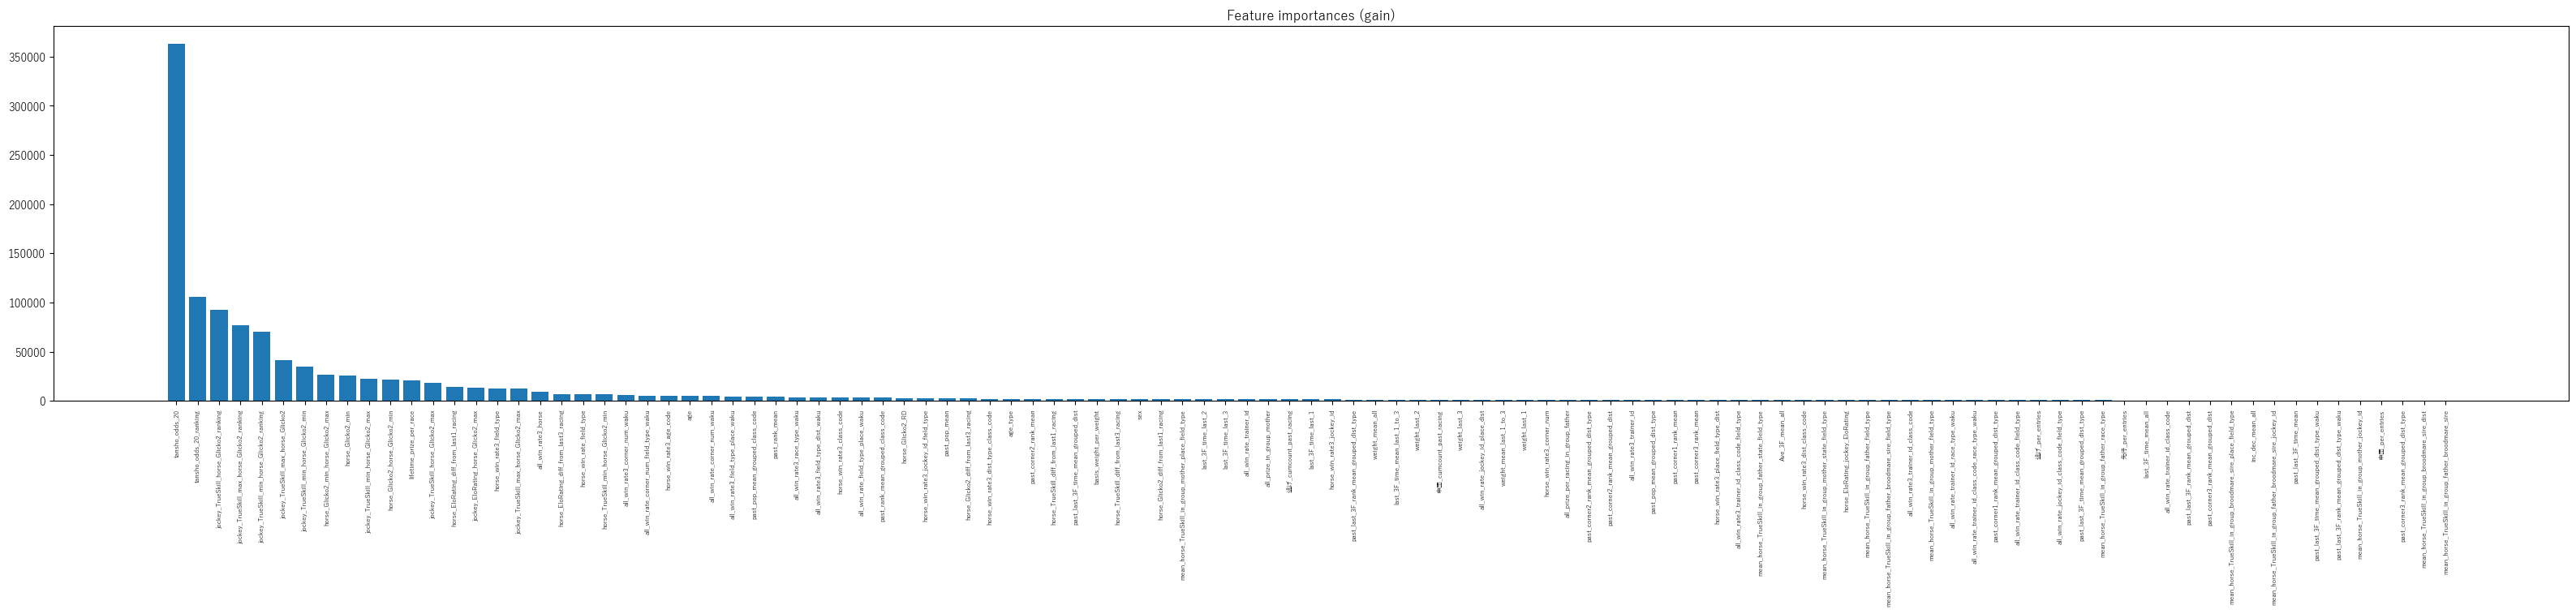

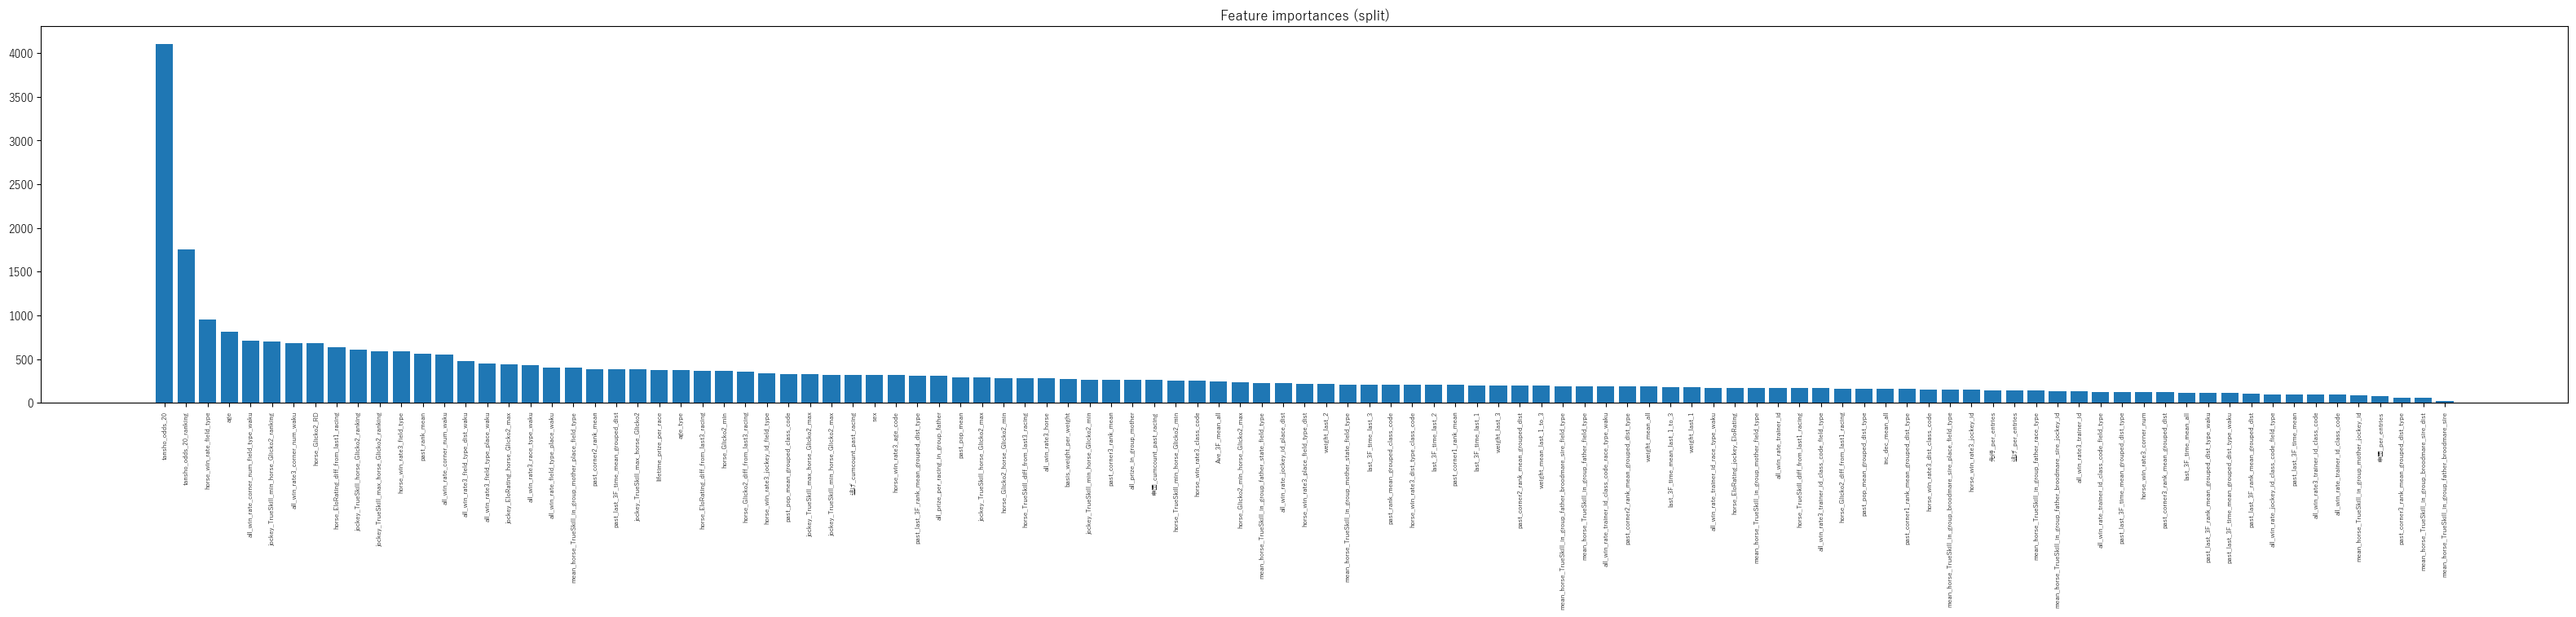

logloss is saved
auc_score is saved


,date,memo,horse_5,horse_6,horse_7,horse_8,horse_9,horse_10,horse_11,horse_12,horse_13,horse_14,horse_15,horse_16,horse_17,horse_18,all_logloss,auc(ovr)
0,2025/07/09 13:44,"base_model + feature selection with lightGBM, ...",1.406849,1.101321,0.977155,1.002813,0.899535,0.827626,0.769064,0.716093,0.690490,0.660548,0.627335,0.586272,0.567926,0.533438,0.639926,0.768559
0,2025/07/07 01:12,"base_model + feature selection with lightGBM, ...",1.406849,1.101321,0.977155,1.002813,0.899535,0.827626,0.769064,0.716093,0.690490,0.660548,0.627335,0.586272,0.567926,0.533438,0.639926,0.768559
1,2025/07/07 01:04,"base_model, n_trials = 100",1.394666,1.169719,0.973155,0.987740,0.887023,0.812936,0.757160,0.715150,0.683703,0.658298,0.626342,0.590029,0.571642,0.542708,0.636240,0.768122
2,2025/07/06 22:19,"n_trials: 5->10, n_trials = 100",1.406849,1.101321,0.977155,1.002813,0.899535,0.827626,0.769064,0.716093,0.690490,0.660548,0.627335,0.586272,0.567926,0.533438,0.639926,0.768559
3,2025/07/06 22:13,"n_trials: 5->10, n_trials = 100",1.406849,1.101321,0.977155,1.002813,0.899535,0.827626,0.769064,0.716093,0.690490,0.660548,0.627335,0.586272,0.567926,0.533438,0.639926,0.768559


In [12]:
memo = "base_model + feature selection with lightGBM, n_trials = 100"
model, df_pred = model_tuner_multi.multi_lightGBM(df5, feature_col3, memo=memo, n_trials=100, save_result=True, visualization=True)

In [ ]:
id = df_pred["id_for_fold"].unique()[60]
tmp = df_pred[df_pred["id_for_fold"] == id][["year", "month", "day", "horse", "pred_class_1", "pred_class_2", "pred_class_3", "target"]]
tmp

,year,month,day,horse,pred_class_1,pred_class_2,pred_class_3,target
316583,2024,11,3,タシロ,0.003922,0.006063,0.013295,0
316584,2024,11,3,メジャークオリティ,0.015226,0.032010,0.038765,0
316585,2024,11,3,タガノアレハンドラ,0.042840,0.063140,0.087640,2
316586,2024,11,3,ユイノマチブセ,0.096675,0.097835,0.103525,0
316587,2024,11,3,タマモヴェナトル,0.261236,0.185580,0.130121,0
316588,2024,11,3,クロースコンバット,0.205171,0.174306,0.131197,1
316589,2024,11,3,サヴァビアン,0.003746,0.007424,0.015248,0
316590,2024,11,3,ブーバー,0.050784,0.062105,0.072529,0
316591,2024,11,3,シャドウレディー,0.015319,0.030517,0.043372,0
316592,2024,11,3,リュクスウォリアー,0.005463,0.008802,0.012042,0


In [ ]:
tmp = df_pred[["id_for_fold", "horse", "pred_class_1"]].sort_values("pred_class_1", ascending=False)
tmp.head(10)

,id_for_fold,horse,pred_class_1
339836,2025050408020406,タマモナポリ,0.533514
338890,2025042705020206,カザンラク,0.497066
345793,2025062102010312,サムシャイン,0.486451
335733,2025040506030309,ピックデムッシュ,0.480507
341767,2025051805020808,フォルラニーニ,0.475149
339894,2025050408020408,ミッキースピネル,0.473872
340785,2025051105020607,シンハナーダ,0.464839
327932,2025020805010303,アドマイヤデイトナ,0.461866
339889,2025050405020408,カニキュル,0.452600
334938,2025032909020110,ミッキースピネル,0.449203


In [ ]:
df_pred[["id_for_fold", "horse", "pred"]].sort_values("pred", ascending=False).tail()

,id_for_fold,horse,pred
251116,2025060805030203,キャバリエクエスト,6.875443e-16
250900,2025060705030107,マジョレル,6.776239e-16
248304,2025051705020705,レオプレセア,6.573031e-16
251244,2025060809030207,フルオブエナジー,6.071034e-16
247317,2025051005020505,パリモード,5.116316e-16


In [ ]:
df_pred[["race_id", "id_for_fold", "horse", "pred", "win_odds", "target"]].to_csv("df_pred.csv", index=False)

In [ ]:
from sklearn.calibration import calibration_curve
from sklearn.metrics import brier_score_loss, log_loss

def plot_calibration_curve(df, y_true_col="target", y_pred_col="pred", title="Calibration curve", n_bins=50):
    y_true = df[y_true_col]
    y_pred = df[y_pred_col]

    prob_true, prob_pred = calibration_curve(y_true, y_pred, n_bins=n_bins, strategy='uniform')

    # 件数を計算
    bin_edges = np.linspace(0, 1, n_bins+1)  # n_bins+1個のbin境界
    bin_ids = np.digitize(y_pred, bin_edges) - 1 

    counts = []
    for i in range(n_bins):
        counts.append(np.sum(bin_ids == i))

    print("Breier Score:",brier_score_loss(y_true, y_pred))
    print("LogLoss:", log_loss(y_true, y_pred))

    # グラフ描画
    plt.plot(prob_pred, prob_true, marker="o", markersize=4)
    plt.plot([0, 1], [0, 1], linestyle="--", alpha=0.7, color="black")
    plt.xlabel("Predicted Probability")
    plt.ylabel("True Probability")
    plt.title(title)

    # 件数をマーカー上に表示
    for x, y, count in zip(prob_pred, prob_true, counts):
        plt.text(x, y + 0.02, str(count), ha='center', va='bottom', fontsize=8)

    plt.tight_layout()
    plt.show()


Breier Score: 0.05693398605038691
LogLoss: 0.20288061810922078


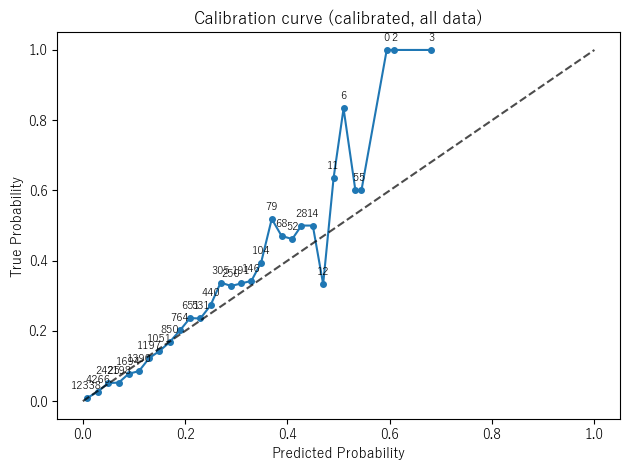

In [ ]:
plot_calibration_curve(df_pred, title="Calibration curve (calibrated, all data)")

Breier Score: 0.03842488086115884
LogLoss: 0.1551610235460004


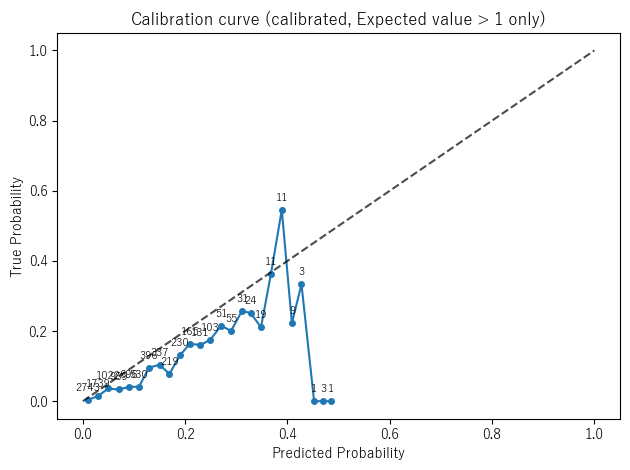

In [ ]:
df_pred["exp_value"] = df_pred["win_odds"] * df_pred["pred"]
plot_calibration_curve(df_pred[df_pred["exp_value"] > 1], title="Calibration curve (calibrated, Expected value > 1 only)")

In [ ]:
tmp = df_pred[["race_id", "id_for_fold", "year", "month", "day", "place", "horse", "pred", "target"]]

,race_id,year,month,day,times,place,daily,race_num,horse,jockey_id,trainer_id,horse_N,waku_num,horse_num,class_code,track_code,corner_num,dist,state,weather,age_code,sex,age,basis_weight,blinker,weight,inc_dec,weight_code,win_odds,win_mul_odds_Hi,win_mul_odds_Lo,rank,time_diff,time,corner1_rank,corner2_rank,corner3_rank,corner4_rank,last_3F_time,last_3F_rank,Ave_3F,PCI,PCI3,RPCI,last_3F_time_diff,leg,pop,prize,error_code,father,mother,broodmare_sire,broodmare_sire_type,horse_color,id,id_for_fold,field_type,flat_or_jump,turn_type,race_type,waku,datetime,age_type,dist_type,target3,weight_last_1,weight_last_2,weight_last_3,weight_mean_last_1_to_3,weight_mean_all,inc_dec_last_1,inc_dec_last_2,inc_dec_last_3,inc_dec_mean_last_1_to_3,inc_dec_mean_all,last_3F_time_last_1,last_3F_time_last_2,last_3F_time_last_3,last_3F_time_mean_last_1_to_3,last_3F_time_mean_all,Ave_3F_last_1,Ave_3F_last_2,Ave_3F_last_3,Ave_3F_mean_last_1_to_3,Ave_3F_mean_all,num_of_entries,中団,先行,後方,逃げ,ﾏｸﾘ,後方_per_entries,後方_cumcount_past_racing,中団_per_entries,中団_cumcount_past_racing,逃げ_per_entries,逃げ_cumcount_past_racing,先行_per_entries,先行_cumcount_past_racing,ﾏｸﾘ_per_entries,ﾏｸﾘ_cumcount_past_racing,past_rank_mean,past_rank_mean_grouped_waku,past_rank_mean_grouped_dist_type,past_rank_mean_grouped_dist,past_rank_mean_grouped_class_code,past_rank_mean_grouped_place,past_rank_mean_grouped_dist_type_waku,past_corner1_rank_mean,past_corner1_rank_mean_grouped_dist_type,past_corner1_rank_mean_grouped_dist,past_corner2_rank_mean,past_corner2_rank_mean_grouped_dist_type,past_corner2_rank_mean_grouped_dist,past_corner3_rank_mean,past_corner3_rank_mean_grouped_dist_type,past_corner3_rank_mean_grouped_dist,past_corner4_rank_mean,past_corner4_rank_mean_grouped_dist_type,past_corner4_rank_mean_grouped_dist,past_pop_mean,past_pop_mean_grouped_dist,past_pop_mean_grouped_dist_type,past_pop_mean_grouped_place,past_pop_mean_grouped_class_code,past_last_3F_rank_mean,past_last_3F_rank_mean_grouped_dist,past_last_3F_rank_mean_grouped_dist_type,past_last_3F_rank_mean_grouped_dist_type_waku,past_last_3F_time_mean,past_last_3F_time_mean_grouped_dist,past_last_3F_time_mean_grouped_dist_type,past_last_3F_time_mean_grouped_dist_type_waku,basis_weight_per_weight,basis_weight_plus_weight,inc_dec_rate,lifetime_prize,lifetime_prize_per_race,interval_day,horse_TrueSkill,horse_TrueSkill_sigma,horse_TrueSkill_min,horse_TrueSkill_max,horse_TrueSkill_after_racing,jockey_TrueSkill,jockey_TrueSkill_sigma,jockey_TrueSkill_min,jockey_TrueSkill_max,jockey_TrueSkill_after_racing,horse_EloRating,horse_EloRating_after_racing,jockey_EloRating,jockey_EloRating_after_racing,horse_Glicko2,horse_Glicko2_RD,horse_Glicko2_min,horse_Glicko2_max,horse_Glicko2_after_racing,horse_TrueSkill_diff_from_last1_racing,horse_TrueSkill_diff_from_last3_racing,jockey_TrueSkill_diff_from_last1_racing,jockey_TrueSkill_diff_from_last3_racing,horse_EloRating_diff_from_last1_racing,horse_EloRating_diff_from_last3_racing,jockey_EloRating_diff_from_last1_racing,jockey_EloRating_diff_from_last3_racing,horse_Glicko2_diff_from_last1_racing,horse_Glicko2_diff_from_last3_racing,horse_TrueSkill horse_TrueSkill_min,horse_TrueSkill horse_TrueSkill_max,horse_TrueSkill jockey_TrueSkill,horse_TrueSkill jockey_TrueSkill_min,horse_TrueSkill jockey_TrueSkill_max,horse_TrueSkill horse_EloRating,horse_TrueSkill jockey_EloRating,horse_TrueSkill horse_Glicko2,horse_TrueSkill horse_Glicko2_min,horse_TrueSkill horse_Glicko2_max,horse_TrueSkill_min horse_TrueSkill_max,horse_TrueSkill_min jockey_TrueSkill,horse_TrueSkill_min jockey_TrueSkill_min,horse_TrueSkill_min jockey_TrueSkill_max,horse_TrueSkill_min horse_EloRating,horse_TrueSkill_min jockey_EloRating,horse_TrueSkill_min horse_Glicko2,horse_TrueSkill_min horse_Glicko2_min,horse_TrueSkill_min horse_Glicko2_max,horse_TrueSkill_max jockey_TrueSkill,horse_TrueSkill_max jockey_TrueSkill_min,horse_TrueSkill_max jockey_TrueSkill_max,horse_TrueSkill_max horse_EloRating,horse_TrueSkill_max jockey_EloRating,horse_T